## Data extraction

First of all, we have to collect all the .wav files into a python data structure. We also have to label the data for the further training and testing. 

In [1]:
import os
import numpy as np
import scipy.io.wavfile as wav
from python_speech_features import mfcc
from matplotlib import pyplot as pl

In [2]:
# Constants
PATH = './vowels'
EXTENSION = '.wav'
N_FEATURES = 13

In [3]:
vowels = os.listdir(PATH)
# Every row of the dataset represents the .wav file
# The first two columns are the sample rate and the data read from the .wav file
# The 3d column is the label of the file
# There exists 6 labels:
labels = {0:'Natural Adult Male', 1:'Natural Adult Female', 2: 'Natural Kid',
         3:'Synthesized Adult Male', 4:'Synthesized Adult Female', 5:'Synthesized Kid'}
dataset = []
features = []
for v in vowels:
    filename, file_extension = os.path.splitext(v)
    if(file_extension == EXTENSION):
        if(v.startswith('nam')):
            class_num = 0
        elif(v.startswith('naf')):
            class_num = 1
        elif(v.startswith('nk')):
            class_num = 2
        elif(v.startswith('sam')):
            class_num = 3
        elif(v.startswith('saf')):
            class_num = 4
        elif(v.startswith('sk')):
            class_num = 5
        sample_rate, X = wav.read(os.path.join(PATH, v))
        dataset.append([sample_rate, X, class_num])
        ceps = mfcc(X, samplerate=sample_rate, nfft=1024)
        features.append([ceps, class_num])
len(dataset)

360

## Man vs Woman

Now we're only interested in audios containing men and women natural voices. First of all, let's extract them from the dataset.

In [4]:
m_features = [] # array containing all features of the men's (natural) voices
f_features = [] # array containing all features of the women's (natural) voices
for f in features:
    if(f[1] == 0): 
        m_features.append(f[0])
    elif(f[1] == 1):
        f_features.append(f[0]) 
m_features = np.array(m_features)
f_features = np.array(f_features)
print(m_features.shape, f_features.shape)
print(m_features[0].shape)
print(m_features[1].shape)
print(f_features[0].shape)

(36,) (36,)
(17, 13)
(23, 13)
(24, 13)


### Feature extraction

As we can see, we've got 36 collections of features for men and women voices. Every audio is split into fragments. For each fragment, the values representing 13 features are calculated.  

In [5]:
def align_by_feature(features):
    '''
    This funciton aligns all the values of the feature of all fragments
    '''
    aligned_features = []
    for i in np.arange(13):
        aligned_features.append([])
    for fragments in features: # loop over every audio 
        for features in fragments:
            for i,feature in enumerate(features):
                aligned_features[i].append(feature)
    return aligned_features

In [6]:
men_aligned = align_by_feature(m_features)
women_aligned = align_by_feature(f_features)
print(len(men_aligned)) 
print(len(men_aligned[0]))
print(len(women_aligned))
print(len(women_aligned[0]))
print(len(men_aligned[1]))
print(len(women_aligned[1]))

13
753
13
919
753
919


In [7]:
def avg_per_audio(features):
    '''
    This function calculates the average feature value for every audio.
    
    input: 
    features: contains N (number of audios) 2d fragments
    fragments: list of arrays, every array contains 13 features
    
    output:
    Nx13 numpy array
    lines: audio index
    column: feature index
    '''
    avg_features = np.zeros((features.shape[0], N_FEATURES))
    for i,audio in enumerate(features):
        sum_per_feature = np.zeros(N_FEATURES)
        for fragment in audio:
            for j, feature in enumerate(fragment):
                sum_per_feature[j] += feature
            avg_features[i, :] = sum_per_feature/float(len(audio))
    return avg_features
men_avg = avg_per_audio(m_features)
women_avg = avg_per_audio(f_features)
print(men_avg.shape)
print(women_avg.shape)

(36, 13)
(36, 13)


Since we we don't want our model to become too complex, we should first select the most convinitent features for the model. Thus, for every feature, we will compare the men and women samples.

### Plotting all of the features of all fragments (aligned)

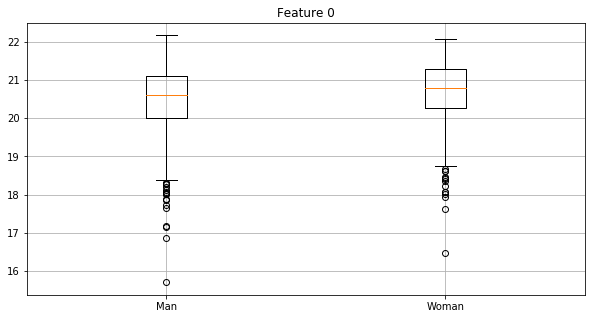

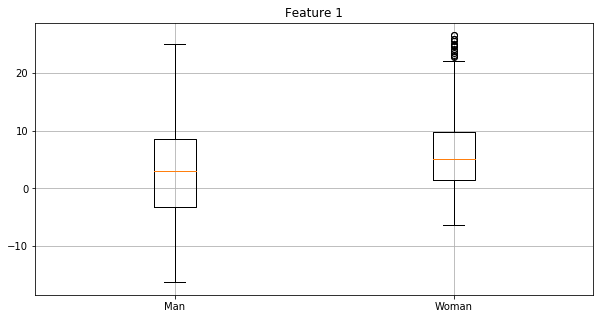

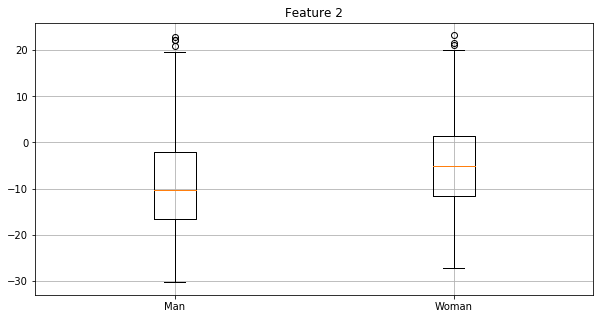

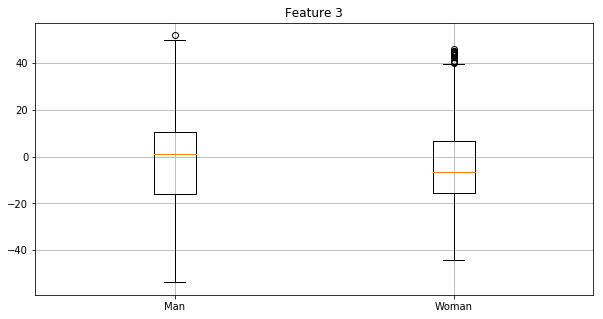

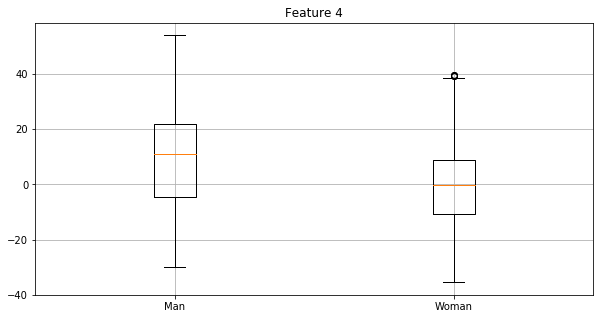

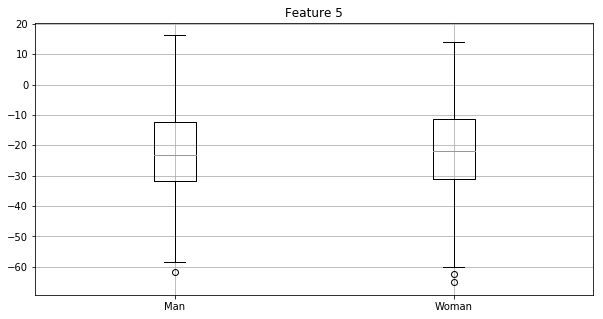

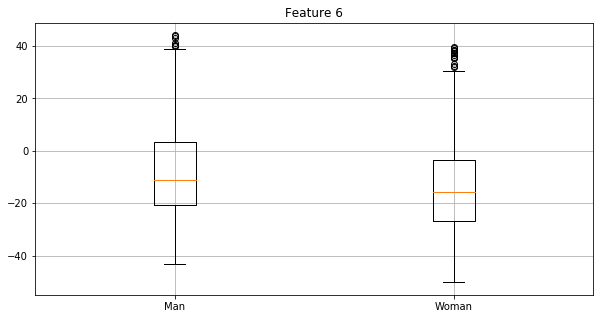

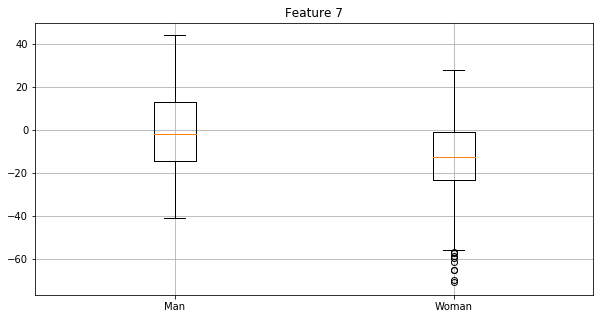

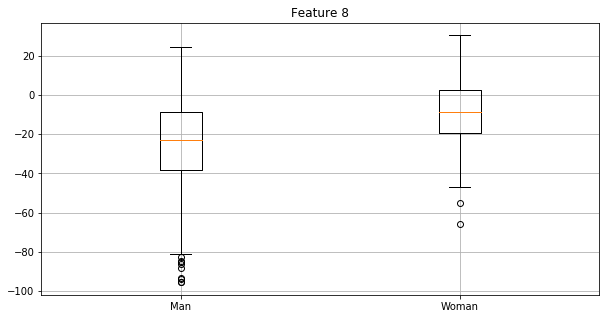

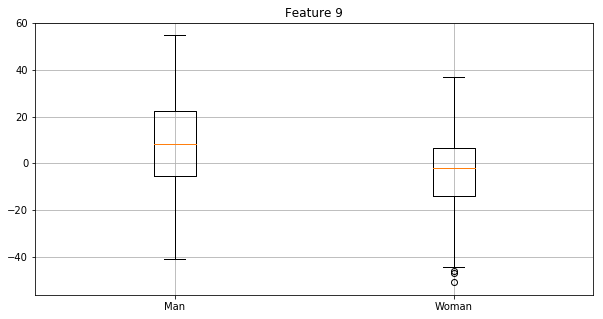

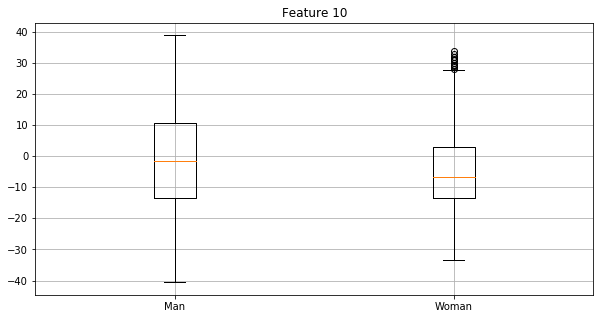

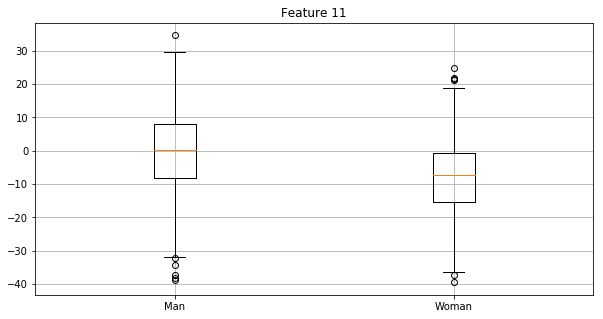

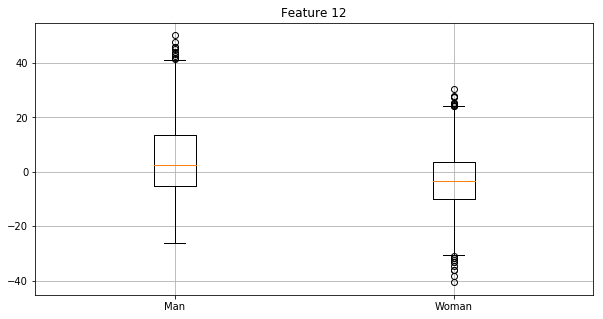

In [8]:
def boxplot_feature(m_features, f_features, k):
    pl.figure(figsize=(10,5))
    feature = np.array([m_features[k], f_features[k]])
    pl.boxplot(feature)
    pl.title('Feature '+ str(k))
    pl.xticks([1, 2], ['Man', 'Woman'])
    pl.grid()

for f in np.arange(13):
    boxplot_feature(men_aligned, women_aligned, f)


### Plotting the features, average per audio

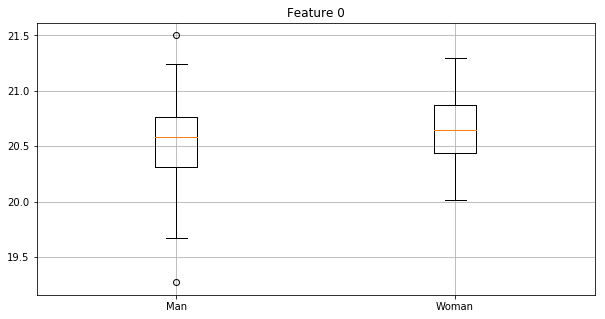

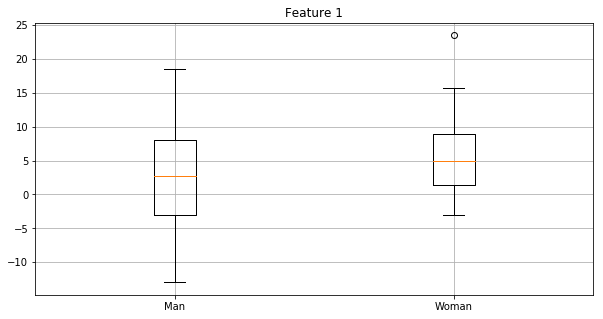

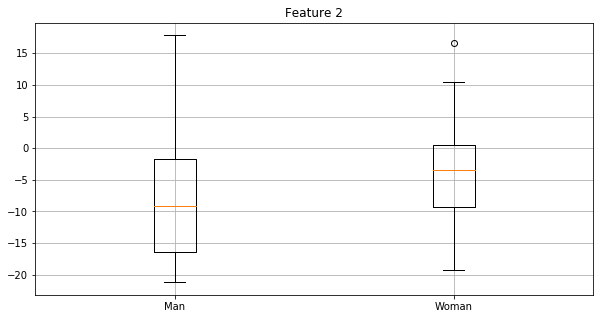

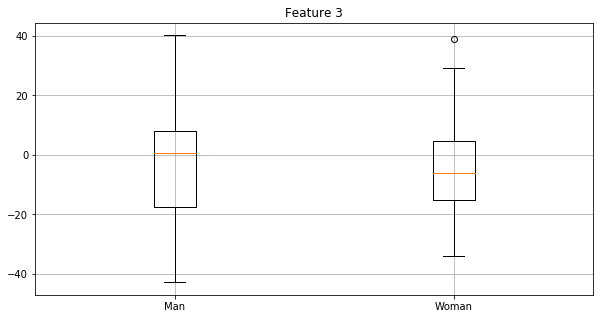

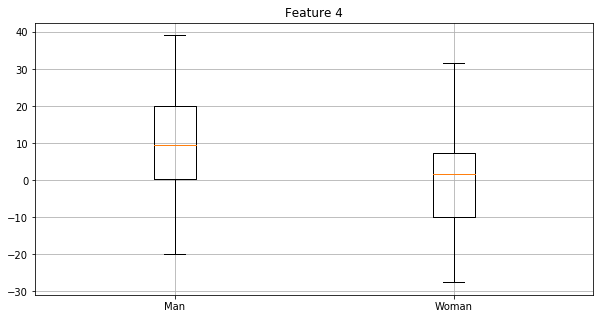

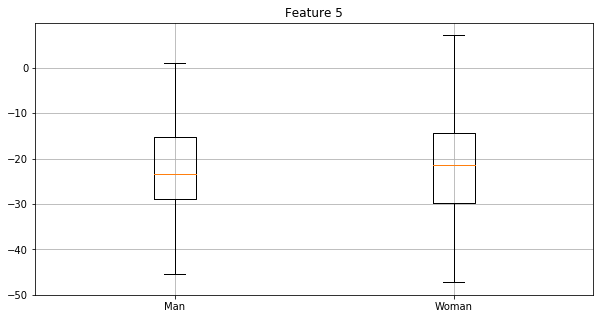

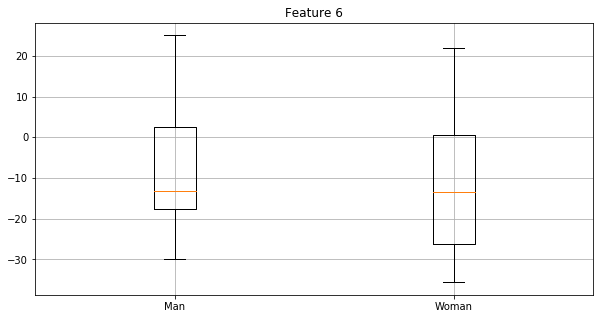

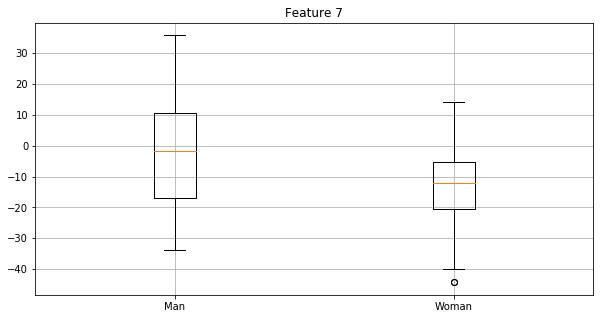

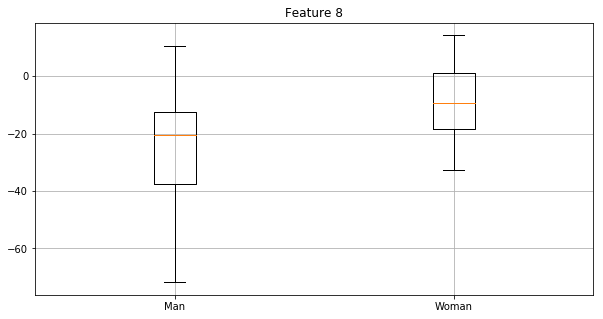

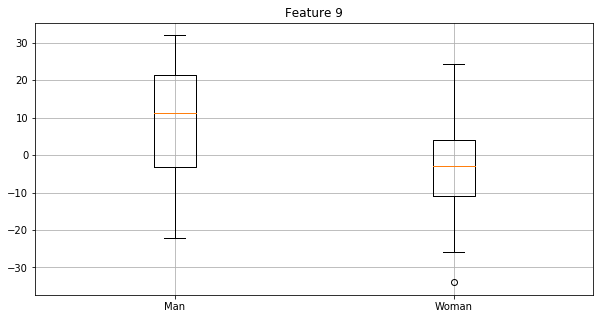

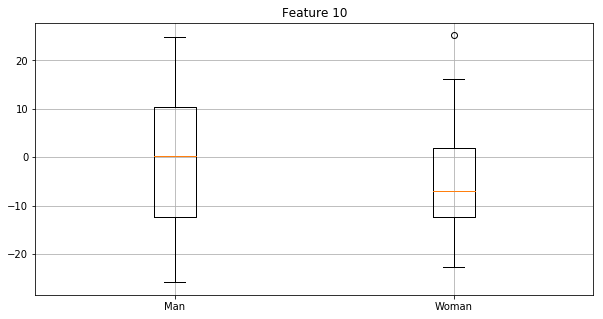

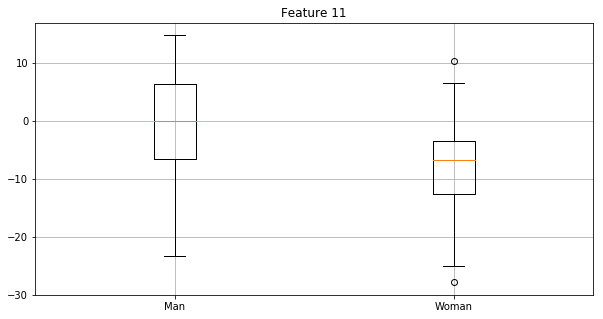

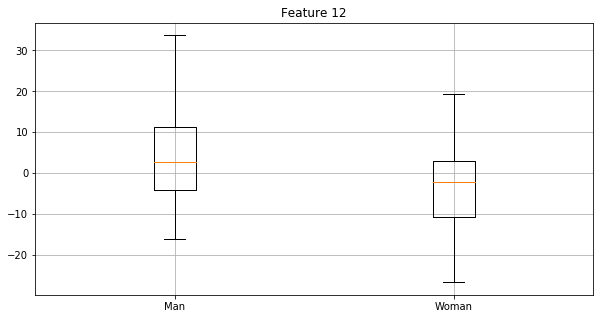

In [9]:
for f in np.arange(N_FEATURES):
    pl.figure(figsize=(10,5))
    pl.boxplot([men_avg.T[f], women_avg.T[f]])
    pl.title('Feature '+ str(f))
    pl.xticks([1, 2], ['Man', 'Woman'])
    pl.grid()

Features 2, 3, 4, 8, 9 look the most distinguishable between men and women.  
Now we will extract the features we're interested in.

In [10]:
# note: features are indexed from 0 to 12
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [11]:
def create_dataset(m_features, f_features, feature_indexes):
    extracted = np.zeros((len(m_features[0]) + len(f_features[0]), len(feature_indexes)+1))
    for i, fi in enumerate(feature_indexes):
        extracted[:, i] = np.concatenate((m_features[fi], f_features[fi]))
    extracted[:, extracted.shape[1]-1] = np.concatenate((np.ones(len(m_features[0])), -1*np.ones(len(f_features[0]))))
    return extracted

In [12]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

In [13]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 5, 8, 16]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [14]:
# input_size = len(selected_features)
# MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
# print(mf_dataset.shape)

# for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
#     print('Testing', h, 'neurons...')
#     nn = mlp.MLP([input_size,h,2], 'tanh')
#     for i in np.arange(N_INITS):                                        # looping over the initializations
#         nn.init_weights()
        
#         MSE[i_h, i, :] = nn.fit((mf_dataset[:,0:input_size], mf_dataset[:,input_size:mf_dataset.shape[1]]),
#                                 learning_rate=LEARNING_RATE,
#                                 momentum=MOMENTUM,
#                                 epochs=EPOCHS)
# print('Tests done')

In [15]:
# pl.figure(figsize=(15,4))
# p_count = 0
# for n in np.arange(MSE.shape[0]):
#     pl.subplot(1, MSE.shape[0], n+1)
#     for i in np.arange(MSE.shape[1]):
#         pl.plot(MSE[n,i,:], c='b')
#     pl.ylim(0,1)
#     pl.xlabel('Epochs')
#     pl.ylabel('MSE')
#     pl.title(str(N_NEURONS[n]) + ' neurons')
#     pl.grid()
# pl.tight_layout()

Tests take too much time, because we consider every fragment.  
To reduce the calculation time, we can reduce the number of inputs (features considered) or reduce the size of the dataset. 
Since we cannot be sure about which features are the best for our classification problem, it will probably be more convinient to reduce the size of the dataset. We first thought of using the average value of the feature per audio. But this method reduces the dataset to only 36 values per feature per class. In addition, using average value can maybe lead to underfitting.  
Instead of considering every fragment, we will normalize the data for every feature: we will create a normally distributed dataset of size *n* for every feature.

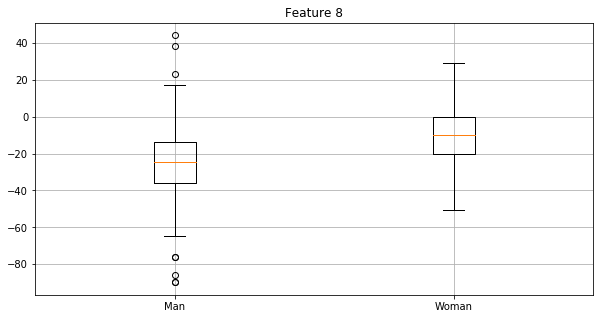

In [16]:
import statistics

def normalize_data(feature_set, n):
    '''
    feature_set has to be an array of length N_FEATURES
    every kth element of this array is the list containing the valeus of the kth feature of all fragments (aligned)
    n : number of points
    '''
    result = np.zeros((N_FEATURES, n))
    for f, values in enumerate(feature_set):
        sd = statistics.stdev(values)
        m = statistics.mean(values)
        normalized = np.random.normal(m, sd, n)
        result[f, :] = normalized
    return result

men_normalized = normalize_data(men_aligned, 200)
women_normalized = normalize_data(women_aligned, 200)

# plot some feature 
pl.figure(figsize=(10,5))
pl.boxplot([men_normalized[8], women_normalized[8]])
pl.title('Feature '+ str(8))
pl.xticks([1, 2], ['Man', 'Woman'])
pl.grid()

In [34]:
N_INITS = 10
N_TESTS = 10
K = 5
EPOCHS = 100
N_NEURONS = [2, 4, 8, 16, 20, 25, 30, 40]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [18]:
# input_size = len(selected_features)
# MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))
# mf_dataset = create_dataset(men_normalized, women_normalized, selected_features)
# print(mf_dataset.shape)

# for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
#     print('Testing', h, 'neurons...')
#     nn = mlp.MLP([input_size,h,1], 'tanh')
#     for i in np.arange(N_INITS):                                        # looping over the initializations
#         nn.init_weights()
        
#         MSE[i_h, i, :] = nn.fit((mf_dataset[:,0:input_size], mf_dataset[:,input_size:mf_dataset.shape[1]]),
#                                 learning_rate=LEARNING_RATE,
#                                 momentum=MOMENTUM,
#                                 epochs=EPOCHS)
# print('Tests done')

In [19]:
# pl.figure(figsize=(15,4))
# p_count = 0
# for n in np.arange(MSE.shape[0]):
#     pl.subplot(1, MSE.shape[0], n+1)
#     for i in np.arange(MSE.shape[1]):
#         pl.plot(MSE[n,i,:], c='b')
#     pl.ylim(0,1)
#     pl.xlabel('Epochs')
#     pl.ylabel('MSE')
#     pl.title(str(N_NEURONS[n]) + ' neurons')
#     pl.grid()
# pl.tight_layout()

In [20]:
mf_dataset = create_dataset(men_aligned, women_aligned, selected_features)
input_size = len(selected_features)
print(men_normalized.shape)
print(women_normalized.shape)
print(mf_dataset.shape)

(13, 200)
(13, 200)
(1672, 14)


In [40]:
# MOMENTUM_LIST = np.arange(0.1, 0.95, 0.2)
# LEARNING_RATE_LIST =np.arange(0.001, 1, 0.1)
MOMENTUM_LIST = np.array([0.1, 0.3, 0.7, 0.9])
LEARNING_RATE_LIST = np.array([0.001, 0.01, 0.1, 0.2, 0.3])
PATH_EXPERIMENTS = './experiments/'
PATH_MW = PATH_EXPERIMENTS + 'MW/'

In [22]:
# MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
# MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

# for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
#     print('Testing', h, 'neurons...')
#     nn = mlp.MLP([input_size,h,1], 'tanh')
#     for i in np.arange(N_TESTS):                                           # looping the tests
#         nn.init_weights()                                                  # the network has to be reinitialized before each test
#         temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
#                                                             mf_dataset,    # but cv.k_fold_cross_validation_per_epoch which
#                                                             k=K,           # returns a value of error per each epoch
#                                                             learning_rate=LEARNING_RATE,
#                                                             momentum=MOMENTUM,
#                                                             epochs=EPOCHS)
#         # temp1 and temp2 are the training and test error. One value per epoch
#         MSE_train[i_h, :, i] = temp1
#         MSE_test[i_h, :, i] = temp2
# print('Tests done')

In [23]:
mf_dataset.shape

(1672, 14)

In [33]:
# import time

# tt = time.time()

# nn = mlp.MLP([input_size,10,1], 'tanh')
# _, _ = cv.k_fold_cross_validation_per_epoch (nn,            # notice that we do not use cv.k_fold_cross_validation
#                                                             mf_dataset,    # but cv.k_fold_cross_validation_per_epoch which
#                                                             k=5,           # returns a value of error per each epoch
#                                                             learning_rate=0.01,
#                                                             momentum=0.5,
#                                                             epochs=100)
# time.time()-tt

In [46]:
# NOTE: the result of these experiments is listed in ./experiments/MW
# Every file contains a 3-dimensional numpy array of shape ((len(N_NEURONS), EPOCHS, N_TESTS))    
# File name convention: 
# Every file is named as follows: {X}_M{Y}L{Z}N{K}_test.npy or {X}_M{Y}L{Z}N{K}_train.npy
#     - X is the index of the experiment, test and train files with the same index correspond to the same experiment
#     - Y is the Momentum used for the experiment
#     - Z is the Learning rate used for the experiment
# Numer of EPOCHS = 100
# Number of tests N_TESTS = 10

# cnt = 0
# for m in MOMENTUM_LIST:
#     print('MOMENTUM:', m)
#     for l in LEARNING_RATE_LIST:
#         print('MOMENTUM:', m, "LEARNING RATE:", l)
        
#         MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
#         MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

#         for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
#             print('Testing', h, 'neurons...')
#             nn = mlp.MLP([input_size,h,1], 'tanh')
#             for i in np.arange(N_TESTS):                                           # looping the tests
#                 tt = time.time()
#                 nn.init_weights()                                                  # the network has to be reinitialized before each test
#                 temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
#                                                             mf_dataset,    # but cv.k_fold_cross_validation_per_epoch which
#                                                             k=K,           # returns a value of error per each epoch
#                                                             learning_rate=l,
#                                                             momentum=m,
#                                                             epochs=EPOCHS)
#                 print (time.time() - tt)
#         # temp1 and temp2 are the training and test error. One value per epoch
#                 MSE_train[i_h, :, i] = temp1
#                 MSE_test[i_h, :, i] = temp2
#         print('Tests done')
#         np.save(PATH_EXPERIMENTS + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
#         np.save(PATH_EXPERIMENTS + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
#         cnt += 1

### Learning Rate

MOMENTUM=0.1, LEARNING RATE=0.001


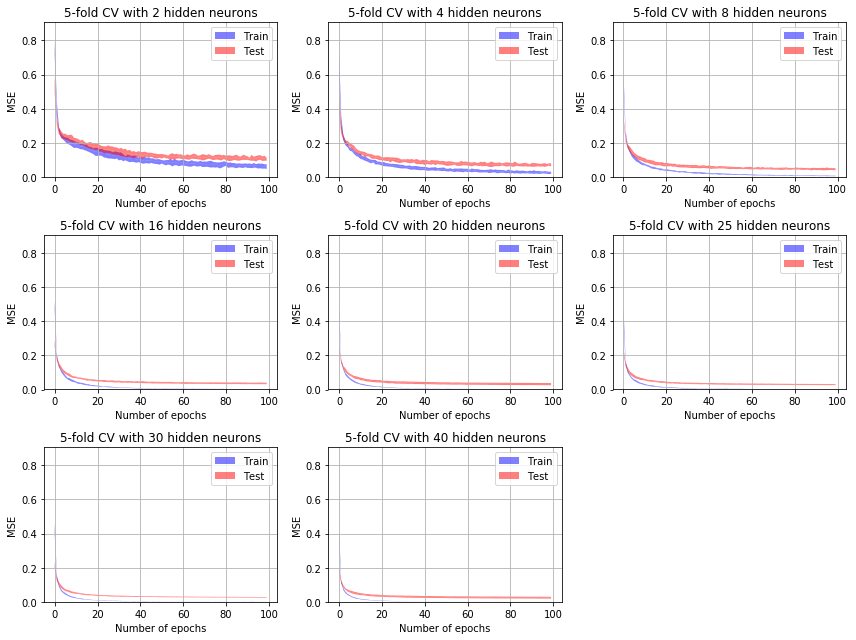

In [43]:
print("MOMENTUM=0.1, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MW + '0_M0.1L0.001N40_train.npy')
MSE_test = np.load(PATH_MW + '0_M0.1L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

MOMENTUM=0.1, LEARNING RATE=0.1


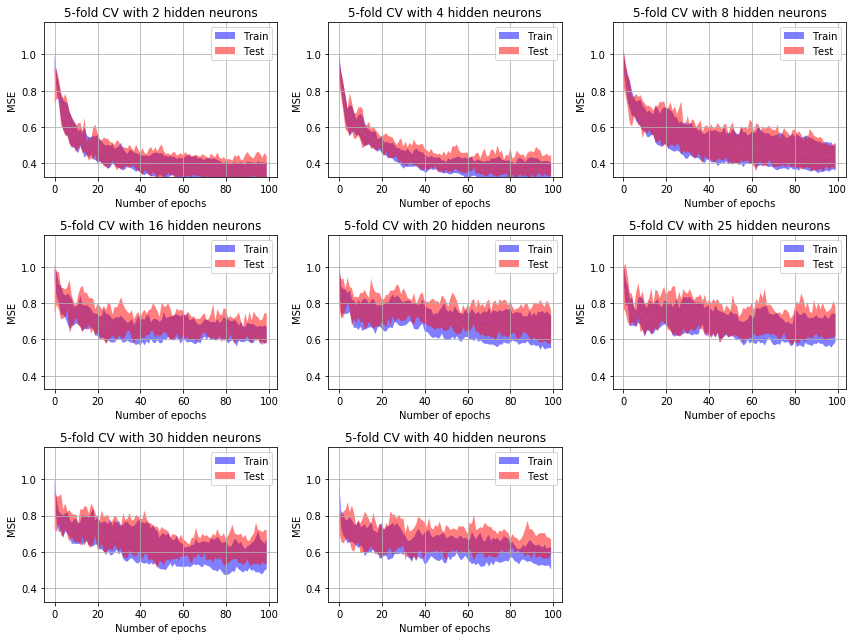

In [47]:
print("MOMENTUM=0.1, LEARNING RATE=0.1")
MSE_train = np.load(PATH_MW + '2_M0.1L0.1N40_train.npy')
MSE_test = np.load(PATH_MW + '2_M0.1L0.1N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

### Momentum

MOMENTUM=0.3, LEARNING RATE=0.001


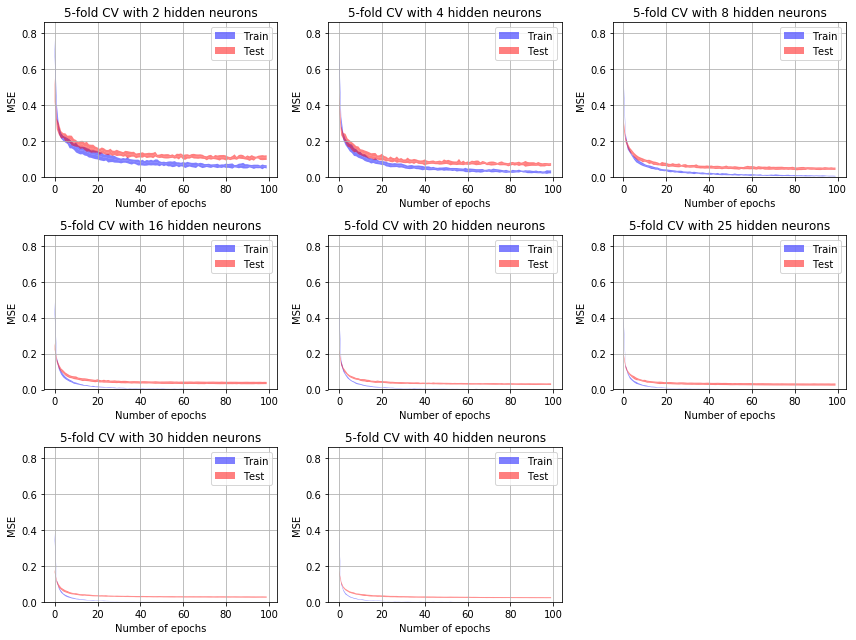

In [50]:
print("MOMENTUM=0.3, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MW + '5_M0.3L0.001N40_train.npy')
MSE_test = np.load(PATH_MW + '5_M0.3L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

MOMENTUM=0.7, LEARNING RATE=0.001


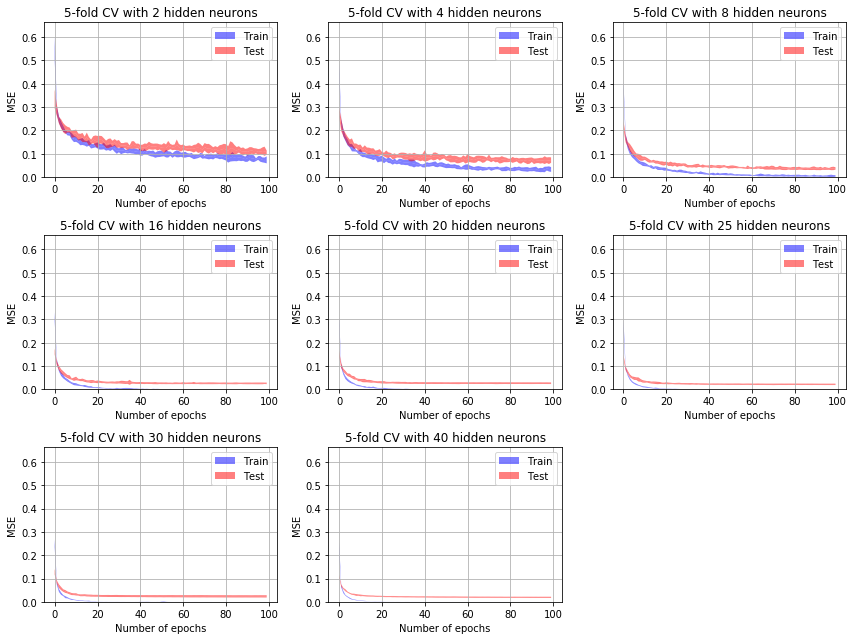

In [52]:
print("MOMENTUM=0.7, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MW + '10_M0.7L0.001N40_train.npy')
MSE_test = np.load(PATH_MW + '10_M0.7L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

### Number of neurons in the hidden layer

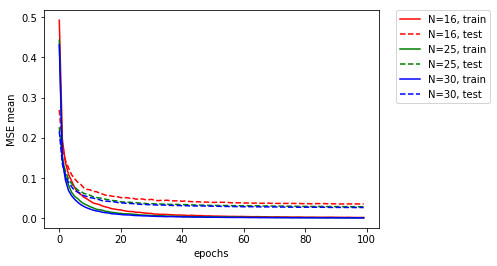

In [79]:
MSE_train = np.load(PATH_MW + '0_M0.1L0.001N40_train.npy')
MSE_test = np.load(PATH_MW + '0_M0.1L0.001N40_test.npy')

# 16 neursons
MSE_train_N16 = MSE_train[3, :, :]
MSE_test_N16 = MSE_test[3, :, :]
MSE_train_N16_mean = np.mean(MSE_train_N16, axis=1)
MSE_test_N16_mean = np.mean(MSE_test_N16, axis=1)

# 25 neurons
MSE_train_N25 = MSE_train[5, :, :]
MSE_test_N25 = MSE_test[5, :, :]
MSE_train_N25_mean = np.mean(MSE_train_N25, axis=1)
MSE_test_N25_mean = np.mean(MSE_test_N25, axis=1)

# 30 neurons
MSE_train_N30 = MSE_train[6, :, :]
MSE_test_N30 = MSE_test[6, :, :]
MSE_train_N30_mean = np.mean(MSE_train_N30, axis=1)
MSE_test_N30_mean = np.mean(MSE_test_N30, axis=1)

pl.plot(MSE_train_N16_mean, 'r', label='N=16, train')
pl.plot(MSE_test_N16_mean, 'r--',label='N=16, test')
pl.plot(MSE_train_N25_mean, 'g', label='N=25, train')
pl.plot(MSE_test_N25_mean, 'g--',label='N=25, test')
pl.plot(MSE_train_N30_mean, 'b', label='N=30, train')
pl.plot(MSE_test_N30_mean, 'b--',label='N=30, test')
pl.xlabel('epochs')
pl.ylabel('MSE mean')
pl.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### The final model

In [82]:
# Final hyperparameters:
M = 0.1      # momentum
L = 0.001    # learning rate
E = 60       # epochs
K = 5        # number of folds
N = 25       # number of neurons
N_TESTS = 10 # number of tests

In [83]:
nn = mlp.MLP([N_FEATURES,N,1], 'tanh')

In [84]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          mf_dataset,
                                                          k=K,
                                                          learning_rate=L,
                                                          momentum=M,
                                                          epochs=E,
                                                          threshold=0.0)

In [135]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.0028002934158736443
MSE test:  0.02751747670200282
Confusion matrix:
[[746.   7.]
 [  8. 911.]]


### Prediciton tests

In [159]:
def mf_predict(file):
    '''
    This function takes the audio filename as a parameter and predicts whether it corresponds to a man or woman voice
    NOTE: the file must be present in ./vowels directory
    '''
    sample_rate, X = wav.read(os.path.join(PATH, file))
    ceps = mfcc(X, samplerate=sample_rate, nfft=1024)
    p = 0
    # collect the predictions for every fragment of an audio
    for i_f, f in enumerate(ceps):
        p_i = nn.predict(f)
        p += p_i
    # calculate the average prediction
    if(p > 0):
        return "Man"
    else:
        return "Woman"

In [137]:
mf_predict('nafdloo.wav') # natural female

'Woman'

In [138]:
mf_predict('safkgil.wav') # synthetized female

'Woman'

In [139]:
mf_predict('namcraa.wav') # natural male

'Man'

In [140]:
mf_predict('sampher.wav') # synthetized male

'Man'

In [141]:
mf_predict('nk7bruu.wav') # natual kid

'Woman'

In [142]:
mf_predict('sk7brer.wav') # synthetized kid

'Woman'

In [145]:
mf_predict('samphil.wav') # synthetized male

'Woman'

In [146]:
mf_predict('samshoo.wav') # synthetized male

'Man'

In [160]:
mf_predict('samshuu.wav') 

'Woman'

In [150]:
mf_predict('safshal.wav')

'Woman'

In [151]:
mf_predict('safkgoo.wav')

'Woman'

In [152]:
mf_predict('samshul.wav')

'Woman'

In [153]:
mf_predict('namcril.wav')

'Man'

In [154]:
mf_predict('namphii.wav')

'Man'

In [155]:
mf_predict('nafdluh.wav')

'Woman'

In [156]:
mf_predict('nafkger.wav')

'Woman'

## Woman vs Kid

Extract audios corresponding to the women's and kids' voices and calculate the features

In [165]:
k_features = [] # array containing all features of the kids' (natural) voices
f_features = [] # array containing all features of the women's (natural) voices
for f in features:
    if(f[1] == 2): 
        k_features.append(f[0])
    elif(f[1] == 1):
        f_features.append(f[0]) 
m_features = np.array(m_features)
f_features = np.array(f_features)
print(m_features.shape, k_features.shape)

(36,) (36,)


In [166]:
# Final hyperparameters:
M = 0.1      # momentum
L = 0.001    # learning rate
E = 60       # epochs
K = 5        # number of folds
N = 25       # number of neurons
N_TESTS = 10 # number of tests
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Align by feature

In [167]:
kids_aligned = align_by_feature(k_features)
women_aligned = align_by_feature(f_features)

Create the dataset. Now the output for the kid's voice will be 1 and the output for the woman's voice will remain -1.

In [168]:
wk_dataset = create_dataset(kids_aligned, women_aligned, selected_features)

In [169]:
nn = mlp.MLP([N_FEATURES,N,1], 'tanh')

In [171]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          wk_dataset,
                                                          k=K,
                                                          learning_rate=L,
                                                          momentum=M,
                                                          epochs=E,
                                                          threshold=0.0)

In [177]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.02432212102038505
MSE test:  0.08778795430088646
Confusion matrix:
[[2811.   55.]
 [  51.  868.]]


In [187]:
MOMENTUM_LIST = [0.1, 0.3, 0.5]
LEARNING_RATE_LIST = [0.001]
N_NEURONS = [30, 40]
EPOCHS = E
PATH_WK = PATH_EXPERIMENTS + 'WK/'

In [184]:
cnt = 3
for m in MOMENTUM_LIST:
    print('MOMENTUM:', m)
    for l in LEARNING_RATE_LIST:
        print('MOMENTUM:', m, "LEARNING RATE:", l)
        
        MSE_train = np.zeros((len(N_NEURONS), E, N_TESTS))
        MSE_test = np.zeros((len(N_NEURONS), E, N_TESTS))

        for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
            print('Testing', h, 'neurons...')
            nn = mlp.MLP([input_size,h,1], 'tanh')
            for i in np.arange(N_TESTS):                                           # looping the tests
                tt = time.time()
                nn.init_weights()                                                  # the network has to be reinitialized before each test
                temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
                                                            wk_dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,           # returns a value of error per each epoch
                                                            learning_rate=l,
                                                            momentum=m,
                                                            epochs=E)
                print (time.time() - tt)
        # temp1 and temp2 are the training and test error. One value per epoch
                MSE_train[i_h, :, i] = temp1
                MSE_test[i_h, :, i] = temp2
        print('Tests done')
        np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
        np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
        cnt += 1

MOMENTUM: 0.1
MOMENTUM: 0.1 LEARNING RATE: 0.001
Testing 30 neurons...
77.65017509460449
79.05043411254883
68.61183500289917
69.37997317314148
70.42466115951538
69.65756607055664
70.17608594894409
70.33172106742859
69.61731314659119
68.16200399398804
Testing 40 neurons...
70.69362998008728
70.94779896736145
70.9411551952362
70.44054007530212
68.98733162879944
69.4730577468872
70.42646813392639
70.03193998336792
69.82092189788818
68.99509596824646
Tests done
MOMENTUM: 0.3
MOMENTUM: 0.3 LEARNING RATE: 0.001
Testing 30 neurons...
67.1445083618164
67.68520188331604
70.36516785621643
81.95048904418945
73.53347730636597
85.22940993309021
66.3332622051239
70.93844771385193
70.04391598701477
70.28055191040039
Testing 40 neurons...
71.88532400131226
72.84780597686768
70.16202187538147
73.14546298980713
71.0622079372406
66.59757089614868
69.02657103538513
67.23395466804504
71.15031504631042
72.97331619262695
Tests done
MOMENTUM: 0.5
MOMENTUM: 0.5 LEARNING RATE: 0.001
Testing 30 neurons...
71.289

### Learning rate, Momentum, Numer of Neurons in the hidden layer

MOMENTUM=0.1, LEARNING RATE=0.001


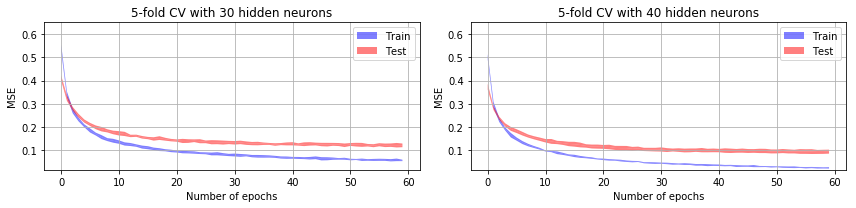

In [188]:
print("MOMENTUM=0.1, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '0_M0.1L0.001N30_train.npy')
MSE_test = np.load(PATH_WK + '0_M0.1L0.001N30_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

MOMENTUM=0.1, LEARNING RATE=0.01


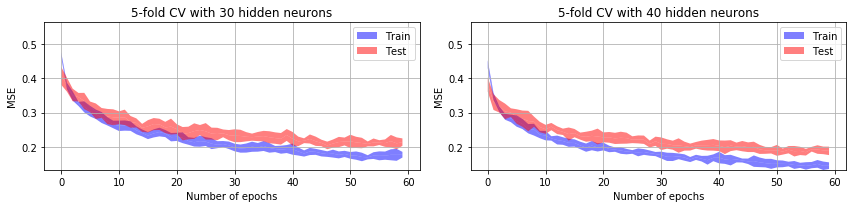

In [189]:
print("MOMENTUM=0.1, LEARNING RATE=0.01")
MSE_train = np.load(PATH_WK + '1_M0.1L0.01N30_train.npy')
MSE_test = np.load(PATH_WK + '1_M0.1L0.01N30_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

MOMENTUM=0.3, LEARNING RATE=0.001


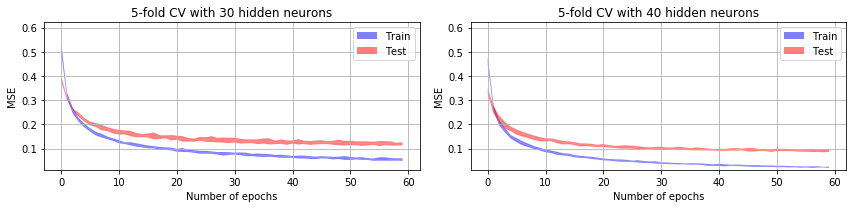

In [190]:
print("MOMENTUM=0.3, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '2_M0.3L0.001N30_train.npy')
MSE_test = np.load(PATH_WK + '2_M0.3L0.001N30_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

MOMENTUM=0.5, LEARNING RATE=0.001


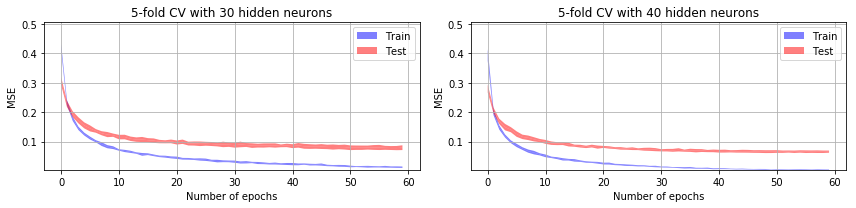

In [191]:
print("MOMENTUM=0.5, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '5_M0.5L0.001N40_train.npy')
MSE_test = np.load(PATH_WK + '5_M0.5L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

The MSE gets better when the value of momentum grows. We will execute some tests with a higher value of momentum and more neurons in the hidden layer

In [192]:
MOMENTUM_LIST = [0.7, 0.9]
LEARNING_RATE_LIST = [0.001]
N_NEURONS = [30, 40]

In [193]:
cnt = 6
for m in MOMENTUM_LIST:
    print('MOMENTUM:', m)
    for l in LEARNING_RATE_LIST:
        print('MOMENTUM:', m, "LEARNING RATE:", l)
        
        MSE_train = np.zeros((len(N_NEURONS), E, N_TESTS))
        MSE_test = np.zeros((len(N_NEURONS), E, N_TESTS))

        for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
            print('Testing', h, 'neurons...')
            nn = mlp.MLP([input_size,h,1], 'tanh')
            for i in np.arange(N_TESTS):                                           # looping the tests
                tt = time.time()
                nn.init_weights()                                                  # the network has to be reinitialized before each test
                temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
                                                            wk_dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,           # returns a value of error per each epoch
                                                            learning_rate=l,
                                                            momentum=m,
                                                            epochs=E)
                print (time.time() - tt)
        # temp1 and temp2 are the training and test error. One value per epoch
                MSE_train[i_h, :, i] = temp1
                MSE_test[i_h, :, i] = temp2
        print('Tests done')
        np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
        np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
        cnt += 1

MOMENTUM: 0.7
MOMENTUM: 0.7 LEARNING RATE: 0.001
Testing 30 neurons...
81.05097985267639
77.62446689605713
78.91765809059143
78.26770496368408
89.15623092651367
93.38646674156189
91.50189709663391
75.32346224784851
87.49186587333679
87.55167388916016
Testing 40 neurons...
82.77499127388
74.93763303756714
80.64520192146301
89.63580894470215
90.00369930267334
75.93544602394104
65.64181184768677
65.77002120018005
67.3543529510498
64.85436224937439
Tests done
MOMENTUM: 0.9
MOMENTUM: 0.9 LEARNING RATE: 0.001
Testing 30 neurons...
63.63530397415161
63.00520586967468
64.01753783226013
62.16509509086609
62.43169093132019
63.511741161346436
64.10153579711914
63.41660809516907
63.115458965301514
62.88342595100403
Testing 40 neurons...
64.61176228523254
64.09917712211609
64.97639727592468
64.16737222671509
65.04154419898987
63.903050899505615
64.65913009643555
65.63166284561157
65.35445523262024
66.61373805999756
Tests done


MOMENTUM=0.7, LEARNING RATE=0.001


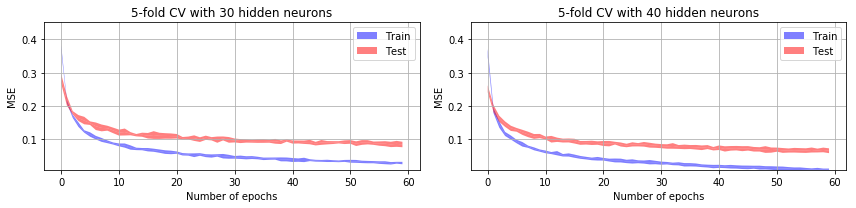

In [194]:
print("MOMENTUM=0.7, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '6_M0.7L0.001N40_train.npy')
MSE_test = np.load(PATH_WK + '6_M0.7L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

MOMENTUM=0.9, LEARNING RATE=0.001


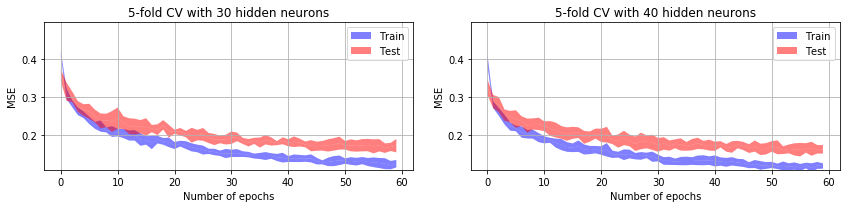

In [195]:
print("MOMENTUM=0.9, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '7_M0.9L0.001N40_train.npy')
MSE_test = np.load(PATH_WK + '7_M0.9L0.001N40_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [197]:
MOMENTUM_LIST = [0.5]
LEARNING_RATE_LIST = [0.001]
N_NEURONS = [40, 50]
EPOCHS = 100
E = 100

In [198]:
cnt = 8
for m in MOMENTUM_LIST:
    print('MOMENTUM:', m)
    for l in LEARNING_RATE_LIST:
        print('MOMENTUM:', m, "LEARNING RATE:", l)
        
        MSE_train = np.zeros((len(N_NEURONS), E, N_TESTS))
        MSE_test = np.zeros((len(N_NEURONS), E, N_TESTS))

        for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
            print('Testing', h, 'neurons...')
            nn = mlp.MLP([input_size,h,1], 'tanh')
            for i in np.arange(N_TESTS):                                           # looping the tests
                tt = time.time()
                nn.init_weights()                                                  # the network has to be reinitialized before each test
                temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
                                                            wk_dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,           # returns a value of error per each epoch
                                                            learning_rate=l,
                                                            momentum=m,
                                                            epochs=E)
                print (time.time() - tt)
        # temp1 and temp2 are the training and test error. One value per epoch
                MSE_train[i_h, :, i] = temp1
                MSE_test[i_h, :, i] = temp2
        print('Tests done')
        np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
        np.save(PATH_WK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
        cnt += 1

MOMENTUM: 0.5
MOMENTUM: 0.5 LEARNING RATE: 0.001
Testing 40 neurons...
121.7558741569519
113.81163620948792
111.2254581451416
111.11468482017517
109.39386510848999
106.18287110328674
105.67259478569031
106.74490714073181
105.24874114990234
108.46462321281433
Testing 50 neurons...
109.7492790222168
109.21798300743103
110.299733877182
131.39253401756287
133.90379190444946
147.66065001487732
123.91963505744934
121.48372220993042
119.54223394393921
120.57340097427368
Tests done


MOMENTUM=0.5, LEARNING RATE=0.001


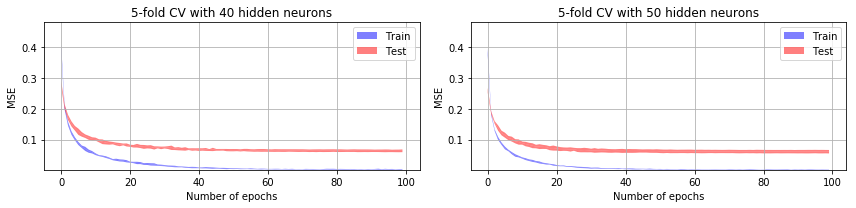

In [202]:
print("MOMENTUM=0.5, LEARNING RATE=0.001")
MSE_train = np.load(PATH_WK + '8_M0.5L0.001N50_train.npy')
MSE_test = np.load(PATH_WK + '8_M0.5L0.001N50_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [203]:
# Final hyperparameters:
M = 0.5      # momentum
L = 0.001    # learning rate
E = 60       # epochs
K = 5        # number of folds
N = 40       # number of neurons
N_TESTS = 10 # number of tests
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [204]:
nn = mlp.MLP([N_FEATURES,N,1], 'tanh')

In [206]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          wk_dataset,
                                                          k=K,
                                                          learning_rate=L,
                                                          momentum=M,
                                                          epochs=E,
                                                          threshold=0.0)

In [208]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.005613162316836096
MSE test:  0.07404281789226343
Confusion matrix:
[[2810.   56.]
 [  33.  886.]]


In [209]:
def wk_predict(file):
    '''
    This function takes the audio filename as a parameter and predicts whether it corresponds to a woman or kid voice
    NOTE: the file must be present in ./vowels directory
    '''
    sample_rate, X = wav.read(os.path.join(PATH, file))
    ceps = mfcc(X, samplerate=sample_rate, nfft=1024)
    p = 0
    # collect the predictions for every fragment of an audio
    for i_f, f in enumerate(ceps):
        p_i = nn.predict(f)
        p += p_i
    # calculate the average prediction
    if(p > 0):
        return "Kid"
    else:
        return "Woman"

In [210]:
wk_predict('nafdlaa.wav')

'Woman'

In [212]:
wk_predict('nafdlel.wav')

'Woman'

In [214]:
wk_predict('nafdluh.wav')

'Woman'

In [216]:
wk_predict('nk3ajil.wav')

'Kid'

In [218]:
wk_predict('nk3araa.wav')

'Kid'

In [220]:
wk_predict('nk3kmaw.wav')

'Kid'

In [222]:
wk_predict('nk3kmer.wav')

'Kid'

In [223]:
wk_predict('safdluu.wav')

'Woman'

In [225]:
wk_predict('safkgal.wav')

'Woman'

In [227]:
wk_predict('safkgul.wav')

'Woman'

In [229]:
wk_predict('sk3ajaa.wav')

'Kid'

In [231]:
wk_predict('sk3ajer.wav')

'Woman'

In [233]:
wk_predict('sk3araa.wav')

'Woman'

In [235]:
wk_predict('sk3araw.wav')

'Kid'

In [237]:
wk_predict('namphaa.wav')

'Woman'

In [239]:
wk_predict('namphee.wav')

'Woman'

In [241]:
wk_predict('samcral.wav')

'Woman'

In [242]:
wk_predict('samcree.wav')

'Woman'

## Man vs Woman vs Kid

In [248]:
print(len(men_aligned[0]))
print(len(men_aligned[1]))
print(len(women_aligned[0]))
print(len(women_aligned[1]))
print(len(kids_aligned[0]))
print(len(kids_aligned[1]))
print(selected_features)

753
753
919
919
2866
2866
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [253]:
# create a dataset with 2 outputs for the 3-classes classifier
def create_dataset_2(m_aligned, w_aligned, k_aligned, selected_features):
    '''
    output layer:
        - man: [1, 1]
        - woman [-1, -1]
        - kid: [1, -1]
    '''
    m_len = len(m_aligned[0])
    w_len = len(w_aligned[0])
    k_len = len(k_aligned[0])
    extracted = np.zeros(((m_len+w_len+k_len), len(selected_features)+2))
    for i, fi in enumerate(selected_features):
        extracted[:, i] = np.concatenate((m_aligned[fi], w_aligned[fi], k_aligned[fi]))
    # first output nodes
    extracted[:, extracted.shape[1]-2] = np.concatenate((np.ones(m_len), -1*np.ones(w_len), np.ones(k_len)))
    extracted[:, extracted.shape[1]-1] = np.concatenate((np.ones(m_len), -1*np.ones(w_len), -1*np.ones(k_len)))
    return extracted

In [254]:
mwk_dataset = create_dataset_2(men_aligned, women_aligned, kids_aligned, selected_features)

In [255]:
mwk_dataset.shape

(4538, 15)

In [256]:
M = 0.5      # momentum
L = 0.001    # learning rate
E = 60       # epochs
K = 5        # number of folds
N = 40       # number of neurons
N_TESTS = 10 # number of tests
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [272]:
nn = mlp.MLP([N_FEATURES,N,2], 'tanh')

In [258]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          mwk_dataset,
                                                          k=K,
                                                          learning_rate=L,
                                                          momentum=M,
                                                          epochs=E,
                                                          threshold=0.0)

In [259]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.007893179064479863
MSE test:  0.05051865353761087
Confusion matrix:
[[3563.  736.]
 [ 741.  730.]]


In [263]:
MOMENTUM_LIST = [0.3, 0.5, 0.7]
LEARNING_RATE_LIST = [0.001]
N_NEURONS = [40, 50]
EPOCHS = E
PATH_MWK = PATH_EXPERIMENTS + 'MWK/'

In [264]:
cnt = 0
for m in MOMENTUM_LIST:
    print('MOMENTUM:', m)
    for l in LEARNING_RATE_LIST:
        print('MOMENTUM:', m, "LEARNING RATE:", l)
        
        MSE_train = np.zeros((len(N_NEURONS), E, N_TESTS))
        MSE_test = np.zeros((len(N_NEURONS), E, N_TESTS))

        for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
            print('Testing', h, 'neurons...')
            nn = mlp.MLP([input_size,h,1], 'tanh')
            for i in np.arange(N_TESTS):                                           # looping the tests
                tt = time.time()
                nn.init_weights()                                                  # the network has to be reinitialized before each test
                temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
                                                            wk_dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,           # returns a value of error per each epoch
                                                            learning_rate=l,
                                                            momentum=m,
                                                            epochs=E)
                print (time.time() - tt)
        # temp1 and temp2 are the training and test error. One value per epoch
                MSE_train[i_h, :, i] = temp1
                MSE_test[i_h, :, i] = temp2
        print('Tests done')
        np.save(PATH_MWK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
        np.save(PATH_MWK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
        cnt += 1

MOMENTUM: 0.3
MOMENTUM: 0.3 LEARNING RATE: 0.001
Testing 40 neurons...
62.938352823257446
70.69826698303223
65.75725412368774
58.57554888725281
58.51782298088074
60.49392580986023
61.72177195549011
81.13318300247192
81.22065091133118
74.56984400749207
Testing 50 neurons...
67.03912305831909
64.32889294624329
64.20287823677063
62.511070013046265
65.74238896369934
78.39098286628723
65.26316690444946
68.98190784454346
66.79738926887512
64.61767578125
Tests done
MOMENTUM: 0.5
MOMENTUM: 0.5 LEARNING RATE: 0.001
Testing 40 neurons...
61.59676218032837
60.909780979156494
61.88361406326294
62.196423292160034
58.42410588264465
58.90593409538269
58.25716209411621
58.654107093811035
58.975533962249756
59.42858910560608
Testing 50 neurons...
71.29561591148376
65.13052797317505
68.72507810592651
70.69261693954468
68.44138717651367
70.85752201080322
76.54009795188904
80.84191989898682
79.56953310966492
66.72618079185486
Tests done
MOMENTUM: 0.7
MOMENTUM: 0.7 LEARNING RATE: 0.001
Testing 40 neurons..

MOMENTUM=0.3, LEARNING RATE=0.001


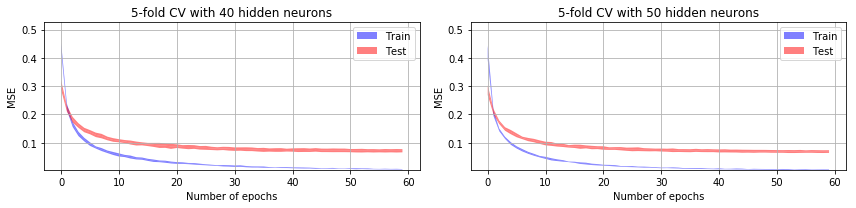

In [267]:
print("MOMENTUM=0.3, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MWK + '0_M0.3L0.001N50_train.npy')
MSE_test = np.load(PATH_MWK + '0_M0.3L0.001N50_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

MOMENTUM=0.5, LEARNING RATE=0.001


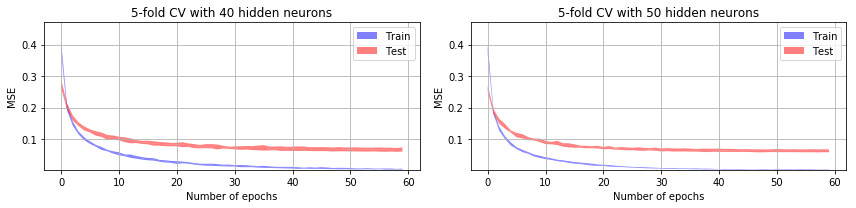

In [269]:
print("MOMENTUM=0.5, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MWK + '1_M0.5L0.001N50_train.npy')
MSE_test = np.load(PATH_MWK + '1_M0.5L0.001N50_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

MOMENTUM=0.7, LEARNING RATE=0.001


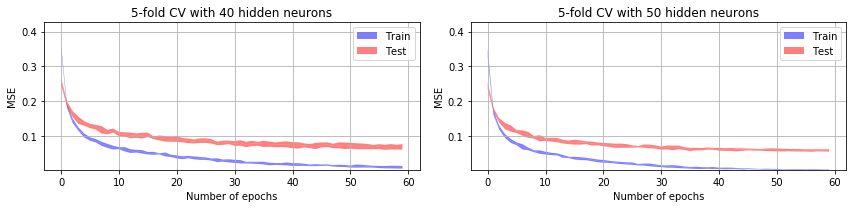

In [271]:
print("MOMENTUM=0.7, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MWK + '2_M0.7L0.001N50_train.npy')
MSE_test = np.load(PATH_MWK + '2_M0.7L0.001N50_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [282]:
MOMENTUM_LIST = [0.5]
LEARNING_RATE_LIST = [0.001]
N_NEURONS = [50, 60]
EPOCHS = E
PATH_MWK = PATH_EXPERIMENTS + 'MWK/'

In [283]:
cnt = 3
for m in MOMENTUM_LIST:
    print('MOMENTUM:', m)
    for l in LEARNING_RATE_LIST:
        print('MOMENTUM:', m, "LEARNING RATE:", l)
        
        MSE_train = np.zeros((len(N_NEURONS), E, N_TESTS))
        MSE_test = np.zeros((len(N_NEURONS), E, N_TESTS))

        for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
            print('Testing', h, 'neurons...')
            nn = mlp.MLP([input_size,h,1], 'tanh')
            for i in np.arange(N_TESTS):                                           # looping the tests
                tt = time.time()
                nn.init_weights()                                                  # the network has to be reinitialized before each test
                temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,            # notice that we do not use cv.k_fold_cross_validation
                                                            wk_dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,           # returns a value of error per each epoch
                                                            learning_rate=l,
                                                            momentum=m,
                                                            epochs=E)
                print (time.time() - tt)
        # temp1 and temp2 are the training and test error. One value per epoch
                MSE_train[i_h, :, i] = temp1
                MSE_test[i_h, :, i] = temp2
        print('Tests done')
        np.save(PATH_MWK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_train', MSE_train)
        np.save(PATH_MWK + str(cnt) + '_M'+str(m)+'L'+str(l)+'N'+str(h)+'_test', MSE_test)
        cnt += 1

MOMENTUM: 0.5
MOMENTUM: 0.5 LEARNING RATE: 0.001
Testing 50 neurons...
61.166118144989014
64.60730910301208
79.88263177871704
63.67534422874451
58.87572622299194
59.6655809879303
58.672626972198486
59.53392505645752
59.13328504562378
59.570940017700195
Testing 60 neurons...
61.79857277870178
62.38840699195862
60.57858204841614
64.85107278823853
66.04605412483215
63.676921129226685
1093.7633080482483
61.287365674972534
60.95937514305115
61.55689597129822
Tests done


MOMENTUM=0.5, LEARNING RATE=0.001


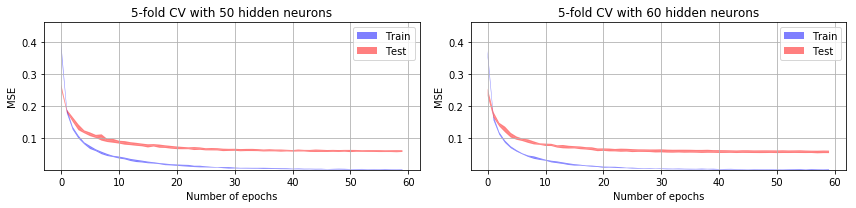

In [287]:
print("MOMENTUM=0.5, LEARNING RATE=0.001")
MSE_train = np.load(PATH_MWK + '3_M0.5L0.001N60_train.npy')
MSE_test = np.load(PATH_MWK + '3_M0.5L0.001N60_test.npy')
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min, 1.2*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [288]:
M = 0.5      # momentum
L = 0.001    # learning rate
E = 60       # epochs
K = 5        # number of folds
N = 50       # number of neurons
N_TESTS = 10 # number of tests
selected_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [289]:
nn = mlp.MLP([N_FEATURES,N,2], 'tanh')

In [290]:
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          mwk_dataset,
                                                          k=K,
                                                          learning_rate=L,
                                                          momentum=M,
                                                          epochs=E,
                                                          threshold=0.0)

In [291]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.0025355790566066417
MSE test:  0.0438624232306885
Confusion matrix:
[[3561.  743.]
 [ 747.  738.]]


In [301]:
def mwk_predict(file):
    '''
    This function takes the audio filename as a parameter and predicts whether it corresponds to a man's, woman's or kid's voice
    NOTE: the file must be present in ./vowels directory
    '''
    sample_rate, X = wav.read(os.path.join(PATH, file))
    ceps = mfcc(X, samplerate=sample_rate, nfft=1024)
    score = np.zeros(2)
    # collect the predictions for every fragment of an audio
    for i_f, f in enumerate(ceps):
        p_i = nn.predict(f)
        score = np.sum([score, p_i], axis=0)
    if(score[0] < 0 and score[1] < 0 ):
        return 'Woman'
    elif (score[0] > 0 and score[1] < 0):
        return 'Kid'
    elif (score[0] > 0 and score[1] > 0):
        return 'Man'
    else:
        return 'Undefined' # chances to reproduce is almost 0

In [302]:
mwk_predict('nafdlaa.wav')

'Woman'

In [303]:
mwk_predict('nafdlel.wav')

'Woman'

In [304]:
mwk_predict('nafdluu.wav')

'Woman'

In [305]:
mwk_predict('namphuh.wav')

'Man'

In [306]:
mwk_predict('namshaw.wav')

'Man'

In [307]:
mwk_predict('namshuh.wav')

'Man'

In [308]:
mwk_predict('nk3ajaw.wav')

'Kid'

In [309]:
mwk_predict('nk3ajuh.wav')

'Kid'

In [310]:
mwk_predict('nk3kmer.wav')

'Kid'

In [311]:
mwk_predict('nk7braw.wav')

'Kid'

In [312]:
mwk_predict('safdlaw.wav')

'Woman'

In [313]:
mwk_predict('safdlil.wav')

'Woman'

In [314]:
mwk_predict('safshii.wav')

'Woman'

In [315]:
mwk_predict('sampher.wav')

'Man'

In [316]:
mwk_predict('samshaa.wav')

'Man'

In [317]:
mwk_predict('samshel.wav')

'Man'

In [318]:
mwk_predict('sk3ajaw.wav')

'Kid'

In [319]:
mwk_predict('sk3ajoo.wav')

'Kid'

In [320]:
mwk_predict('sk5mgaw.wav')

'Kid'